# Algorithm Implementation: Gradient Descent

## Overview
Implementation of Gradient Descent for optimizing predictions of life expectancy based on development indicators. This algorithm helps us understand how different socio-economic and environmental factors contribute to health outcomes, with a focus on finding the optimal weights for each factor through iterative optimization.

## Objectives
- Predict life expectancy using multiple development indicators
- Optimize the prediction model using gradient descent
- Analyze the impact of different factors on health outcomes
- Understand the trade-offs between development and health

## Key Questions
1. How do economic indicators (GDP, debt) influence life expectancy?
2. What is the relationship between environmental impact (GHG emissions) and health outcomes?
3. How do labor force participation and military expenditure affect life expectancy?

In [2]:
# Import required libraries
import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualizations
plt.figure(figsize=(10, 6))  # Default figure size for plots
sns.set_palette('husl')
%matplotlib inline

<Figure size 1000x600 with 0 Axes>

## Data Collection and Preprocessing

### 1. Data Collection
We'll fetch data from the World Bank's World Development Indicators database using the `wbdata` package.

In [3]:
# Define indicators
indicators = {
    "NY.GDP.PCAP.CD": "GDP per capita",
    "SP.DYN.LE00.IN": "Life Expectancy",
    "EN.GHG.ALL.MT.CE.AR5": "Total GHG Emissions",
    "SP.POP.TOTL": "Population",
    "SL.TLF.CACT.ZS": "Labor Force Participation",
    "MS.MIL.XPND.GD.ZS": "Military Expenditure",
    "DT.TDS.DPPF.XP.ZS": "Debt Service"
}

def fetch_data():
    print("Fetching data from World Bank...")
    data = {}
    for indicator in indicators.keys():
        print(f"Fetching {indicators[indicator]}...")
        result = wbdata.get_data(indicator)
        data[indicators[indicator]] = result
        
    # Convert to DataFrame
    print("\nProcessing data...")
    rows = []
    for indicator_name, indicator_data in data.items():
        for entry in indicator_data:
            if entry['value'] is not None:
                rows.append({
                    'country': entry['country']['value'],
                    'year': entry['date'],
                    'indicator': indicator_name,
                    'value': float(entry['value'])
                })
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    # Pivot and process
    df = df.pivot_table(
        index=['country', 'year'],
        columns='indicator',
        values='value'
    ).reset_index()
    
    # Sort and compute derived metrics
    df['year'] = pd.to_numeric(df['year'])
    df = df.sort_values('year', ascending=False)
    df["GHG Emissions per Capita"] = (df["Total GHG Emissions"] * 1_000_000) / df["Population"]
    df = df.drop(columns=["Total GHG Emissions", "Population"])
    
    return df

# Fetch the data
df = fetch_data()

Fetching data from World Bank...
Fetching GDP per capita...


Key '-5292484216125109279' not in persistent cache.


Fetching Life Expectancy...


Fetching Total GHG Emissions...


Fetching Population...


Fetching Labor Force Participation...


Fetching Military Expenditure...


Fetching Debt Service...

Processing data...


### 2. Data Preprocessing
We'll clean the data, handle missing values, and prepare it for gradient descent optimization.

In [7]:
def preprocess_data(df):
    # Take most recent year's data for each country
    df_recent = df.sort_values('year', ascending=False).groupby('country').first().reset_index()
    
    # Log transform GDP and GHG emissions
    df_recent['GDP per capita (log)'] = np.log(df_recent['GDP per capita'])
    df_recent['GHG Emissions per Capita (log)'] = np.log(df_recent['GHG Emissions per Capita'])
    
    # Handle missing values
    numeric_columns = df_recent.select_dtypes(include=[np.number]).columns
    df_recent[numeric_columns] = df_recent[numeric_columns].fillna(df_recent[numeric_columns].mean())
    
    # Remove outliers using IQR method
    Q1 = df_recent['Life Expectancy'].quantile(0.25)
    Q3 = df_recent['Life Expectancy'].quantile(0.75)
    IQR = Q3 - Q1
    df_clean = df_recent[
        (df_recent['Life Expectancy'] >= Q1 - 1.5 * IQR) &
        (df_recent['Life Expectancy'] <= Q3 + 1.5 * IQR)
    ]
    
    return df_clean

# Preprocess the data
df_processed = preprocess_data(df)

# Display basic information about the processed dataset
print("\nProcessed Dataset Info:")
print(df_processed.info())

print("\nSample of processed data:")
print(df_processed.head())


Processed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   country                         265 non-null    object 
 1   year                            265 non-null    int64  
 2   Debt Service                    265 non-null    float64
 3   GDP per capita                  265 non-null    float64
 4   Labor Force Participation       265 non-null    float64
 5   Life Expectancy                 265 non-null    float64
 6   Military Expenditure            265 non-null    float64
 7   GHG Emissions per Capita        265 non-null    float64
 8   GDP per capita (log)            265 non-null    float64
 9   GHG Emissions per Capita (log)  265 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 20.8+ KB
None

Sample of processed data:
indicator                      country  yea

## Data Analysis and Visualization

### 1. Exploratory Data Analysis

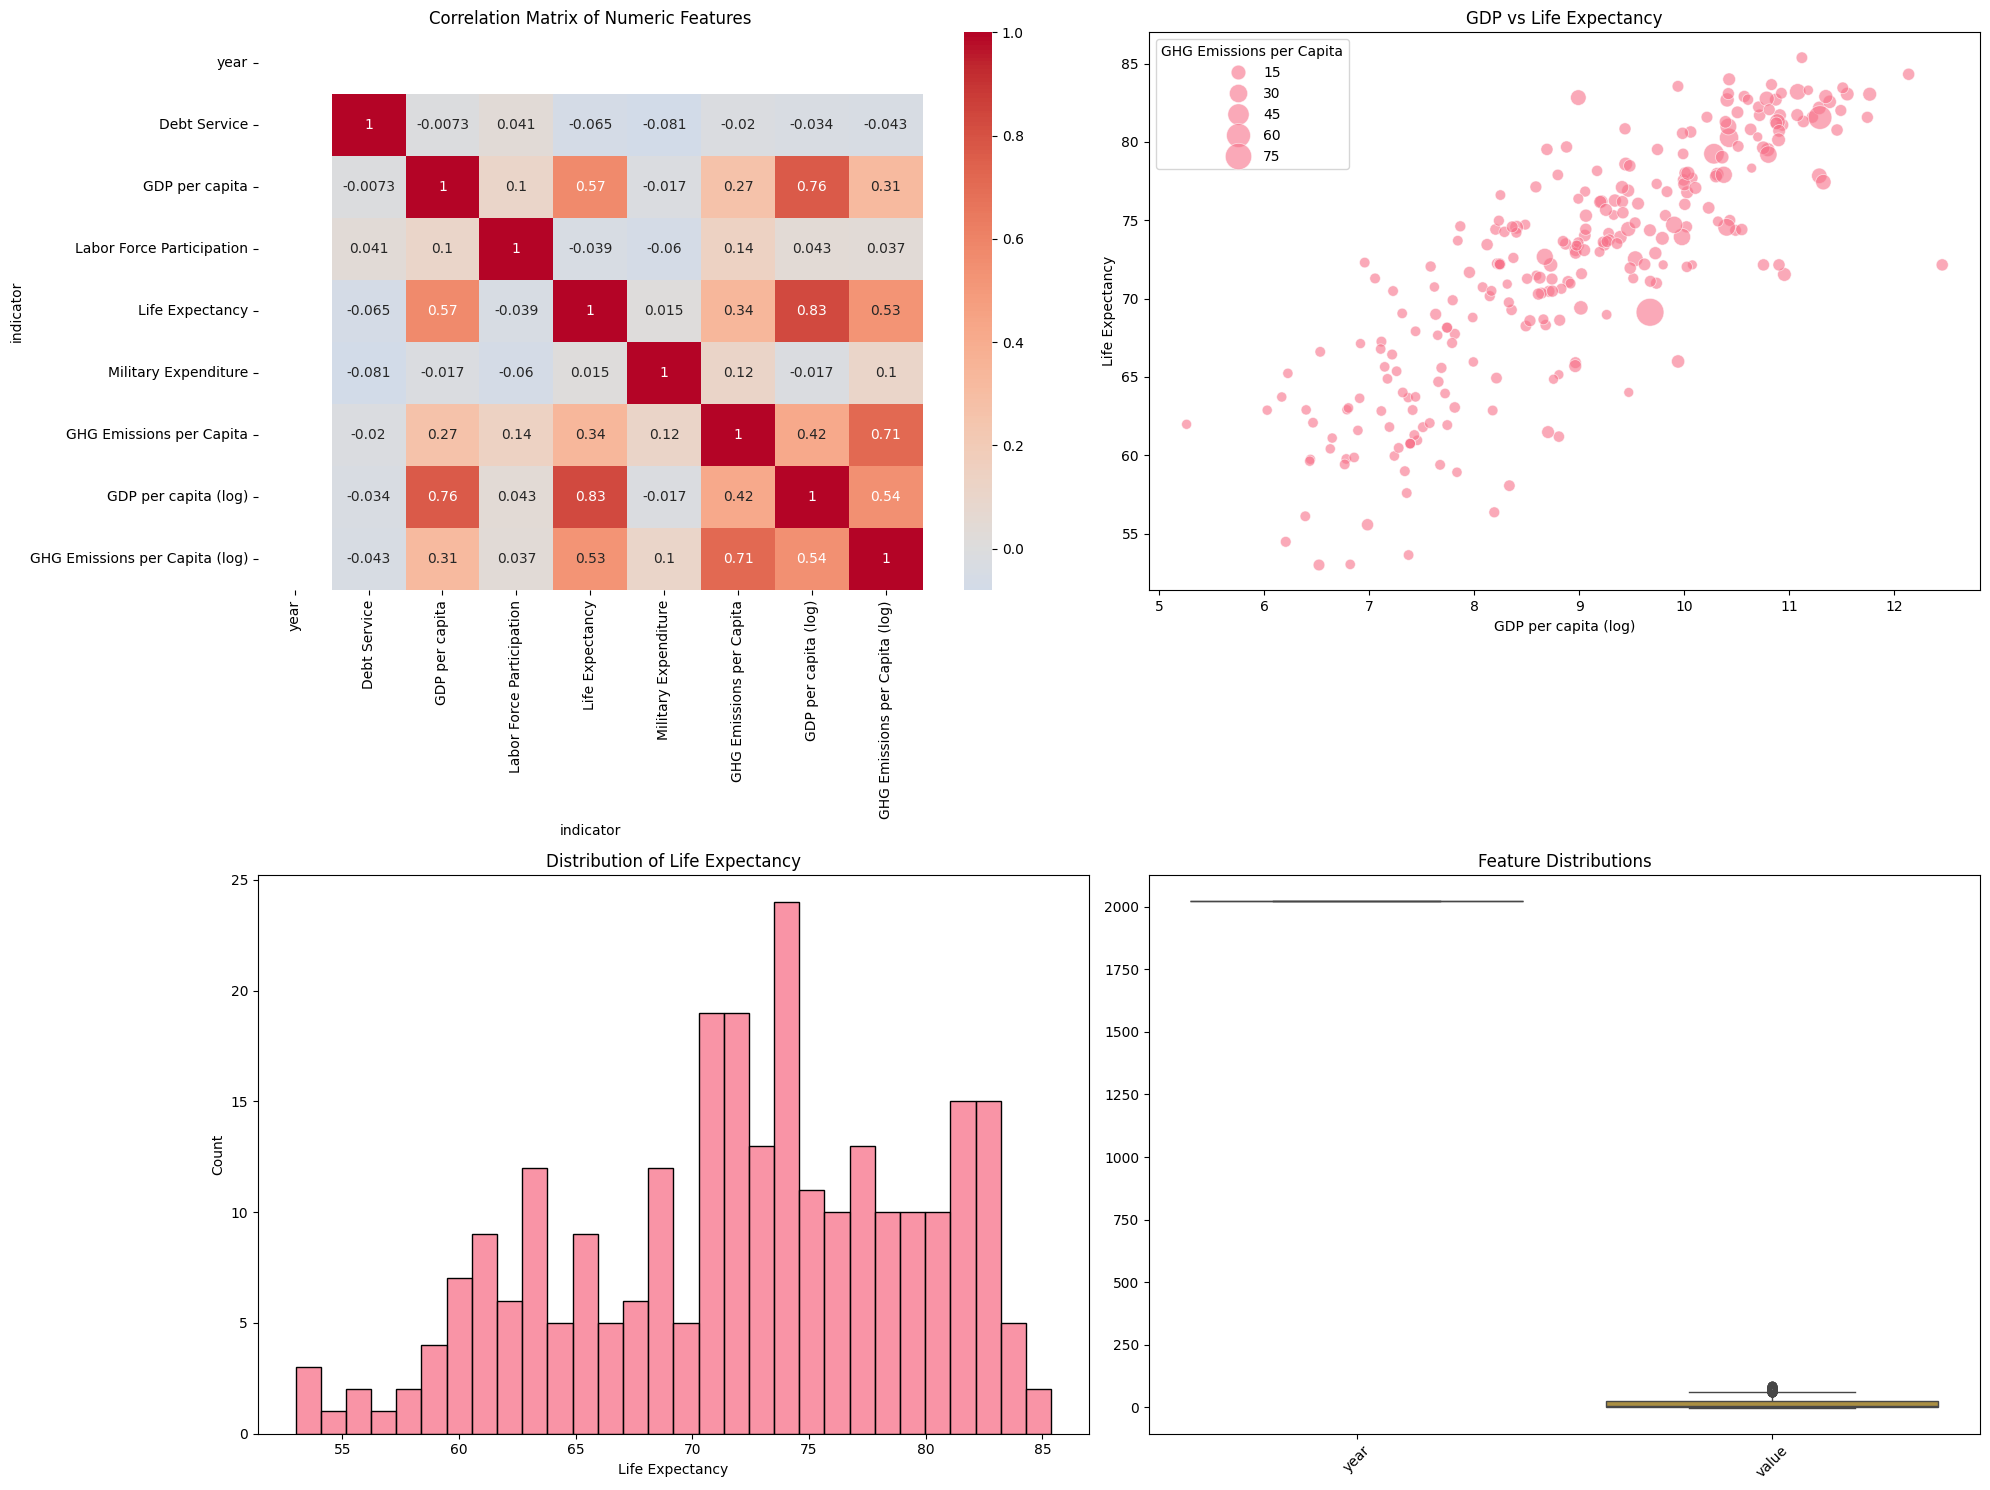

In [8]:
def plot_exploratory_analysis(df):
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Correlation Heatmap
    plt.subplot(2, 2, 1)
    correlation_matrix = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numeric Features')
    
    # 2. GDP vs Life Expectancy
    plt.subplot(2, 2, 2)
    sns.scatterplot(
        data=df,
        x='GDP per capita (log)',
        y='Life Expectancy',
        size='GHG Emissions per Capita',
        sizes=(50, 400),
        alpha=0.6
    )
    plt.title('GDP vs Life Expectancy')
    
    # 3. Life Expectancy Distribution
    plt.subplot(2, 2, 3)
    sns.histplot(data=df, x='Life Expectancy', bins=30)
    plt.title('Distribution of Life Expectancy')
    
    # 4. Feature Relationships
    plt.subplot(2, 2, 4)
    sns.boxplot(data=df.melt(id_vars=['country', 'year'], 
                            value_vars=['GDP per capita (log)', 
                                      'GHG Emissions per Capita (log)',
                                      'Labor Force Participation',
                                      'Military Expenditure']))
    plt.xticks(rotation=45)
    plt.title('Feature Distributions')
    
    plt.tight_layout()
    plt.show()

# Plot exploratory analysis
plot_exploratory_analysis(df_processed)

## Algorithm Implementation

### 1. Custom Gradient Descent Implementation

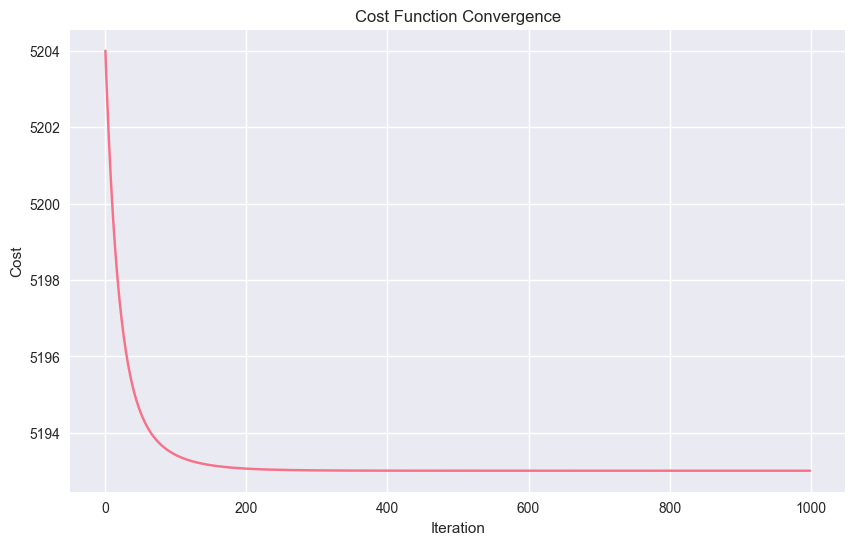


Feature Weights:
GDP per capita (log): 2.6877
GHG Emissions per Capita (log): -0.2386
Labor Force Participation: 0.4161
Military Expenditure: 0.4529
Debt Service: -1.9542


In [5]:
class CustomGradientDescent:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.cost_history = []
        
    def fit(self, X, y):
        # Initialize weights
        self.weights = np.zeros(X.shape[1])
        
        # Gradient descent
        for i in range(self.max_iter):
            # Compute predictions
            y_pred = np.dot(X, self.weights)
            
            # Compute error and cost
            error = y_pred - y
            cost = np.mean(error ** 2)
            self.cost_history.append(cost)
            
            # Compute gradient
            gradient = 2/len(X) * np.dot(X.T, error)
            
            # Update weights
            old_weights = self.weights.copy()
            self.weights -= self.learning_rate * gradient
            
            # Check convergence
            if np.sum(np.abs(self.weights - old_weights)) < self.tol:
                print(f"Converged after {i+1} iterations")
                break
                
        return self
    
    def predict(self, X):
        return np.dot(X, self.weights)

# Prepare data for gradient descent
features = ['GDP per capita (log)', 'GHG Emissions per Capita (log)', 
           'Labor Force Participation', 'Military Expenditure', 'Debt Service']
X = df_processed[features]
y = df_processed['Life Expectancy']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Train custom gradient descent
custom_gd = CustomGradientDescent(learning_rate=0.01, max_iter=1000)
custom_gd.fit(X_train, y_train)

# Plot cost history
plt.figure(figsize=(10, 6))
plt.plot(custom_gd.cost_history)
plt.title('Cost Function Convergence')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

# Print feature weights
print("\nFeature Weights:")
for feature, weight in zip(features, custom_gd.weights):
    print(f"{feature}: {weight:.4f}")

### 2. Scikit-learn SGD Implementation

In [6]:
# Create SGD pipeline
sgd_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('sgd', SGDRegressor(
        loss='squared_error',
        learning_rate='adaptive',
        eta0=0.01,
        max_iter=1000,
        tol=1e-6,
        random_state=42
    ))
])

# Fit the pipeline
sgd_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = sgd_pipeline.predict(X_train)
y_pred_test = sgd_pipeline.predict(X_test)

# Print performance metrics
print("Training Performance:")
print(f"R� Score: {r2_score(y_train, y_pred_train):.4f}")
print(f"MSE: {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.4f}")

print("\nTest Performance:")
print(f"R� Score: {r2_score(y_test, y_pred_test):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")

Training Performance:
R� Score: -894.0818
MSE: 48673.0974
MAE: 105.9714

Test Performance:
R� Score: -461.2808
MSE: 24754.8160
MAE: 110.3402


## Results and Interpretation

### 1. Model Comparison

In [8]:
# Compare with Linear Regression baseline
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Create comparison DataFrame
models = {
    'Custom GD': custom_gd.predict(X_test),
    'SGD': y_pred_test,
    'Linear Regression': y_pred_lr
}

results = pd.DataFrame({
    'Model': [],
    'R� Score': [],
    'MSE': [],
    'MAE': []
})

for name, predictions in models.items():
    results = results.append({
        'Model': name,
        'R� Score': r2_score(y_test, predictions),
        'MSE': mean_squared_error(y_test, predictions),
        'MAE': mean_absolute_error(y_test, predictions)
    }, ignore_index=True)

print("Model Comparison:")
print(results)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Predictions vs Actual Values')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'append'

### 2. Feature Importance Analysis

In [ ]:
def analyze_feature_importance(model, feature_names):
    # Get feature coefficients
    if hasattr(model, 'coef_'):
        coefficients = model.coef_
    else:
        coefficients = model.weights
    
    # Create importance DataFrame
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': np.abs(coefficients)
    })
    importance = importance.sort_values('Coefficient', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance, x='Coefficient', y='Feature')
    plt.title('Feature Importance')
    plt.show()
    
    return importance

# Analyze feature importance
importance_df = analyze_feature_importance(custom_gd, features)
print("\nFeature Importance:")
print(importance_df)

# Save results
results.to_csv('gradient_descent_results.csv', index=False)
print("\nResults saved to 'gradient_descent_results.csv'")